(lqc)=
```{raw} jupyter
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# LQ控制：基础

```{index} single: LQ控制
```

```{contents} 目录
:depth: 2
```

除了Anaconda中已有的库外，本讲座还需要以下库：

In [1]:
!pip install quantecon

## 概述

线性二次（linear–quadratic，LQ）控制指的是一类在几乎所有科学领域都有应用的动态优化问题。

正如我们将看到的，LQ 系统具有简洁的结构，使其成为解决各类经济问题的主力工具。

此外，尽管线性二次结构看似具有约束性，它的实际灵活性远超最初印象。

此外，虽然线性二次结构具有局限性，但实际上它比最初看起来要灵活得多。

这些主题将在下文中会反复出现。

从数学角度来看，LQ控制问题与{doc}`卡尔曼滤波<kalman>`密切相关

* 线性二次控制问题和卡尔曼滤波问题的递归表述都涉及矩阵**黎卡提方程**。

* 线性控制和线性滤波问题的经典表述使用类似的矩阵分解（参见[这个讲座](https://python-advanced.quantecon.org/lu_tricks.html)和[这个讲座](https://python-advanced.quantecon.org/classical_filtering.html)）。

阅读下文时，熟悉以下内容会更有帮助：

* 矩阵运算
* 随机变量向量
* 动态规划和贝尔曼方程（参见{doc}`这个讲座 <intro:short_path>`和{doc}`这个讲座 <optgrowth>`）

关于LQ控制的更多阅读材料，请参见：

* {cite}`Ljungqvist2012`，第5章
* {cite}`HansenSargent2008`，第4章
* {cite}`HernandezLermaLasserre1996`，3.5节

为了专注于计算，我们将较长的证明留给这些参考资料（同时尽可能提供直观解释）。

让我们从一些导入开始：

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

import numpy as np
from quantecon import LQ

## 引言

LQ 中的“线性（linear）”部分指的是状态变量的线性运动规律，而“二次（quadratic）”部分指的是偏好。

我们将从前者开始，然后讨论后者，最后把它们结合起来构成一个优化问题。

### 运动规律

设 $x_t$ 是描述某个经济系统状态的向量。

假设 $x_t$ 遵循以下线性运动规律

```{math}
:label: lq_lom

x_{t+1} = A x_t + B u_t + C w_{t+1},
\qquad t = 0, 1, 2, \ldots
```

这里

* $u_t$ 是一个“控制”向量，包含了决策者面对当前状态 $x_t$ 时可用的选择
* $\{w_t\}$ 是一个均值为零、互不相关的冲击过程，满足 $\mathbb E w_t w_t' = I$，其中右边是单位矩阵

关于维度的规定如下：

* $x_t$ 是 $n \times 1$ 维，$A$ 是 $n \times n$ 维
* $u_t$ 是 $k \times 1$ 维，$B$ 是 $n \times k$ 维
* $w_t$ 是 $j \times 1$ 维，$C$ 是 $n \times j$ 维

#### 示例1

考虑一个家庭预算约束，表示为

$$
a_{t+1} + c_t = (1 + r) a_t + y_t
$$

这里 $a_t$ 是资产，$r$ 是固定利率，$c_t$ 是当期消费，$y_t$ 是当期非金融收入。

假设 $\{ y_t \}$ 是序列不相关的，且服从 $N(0, \sigma^2)$ 分布。令$\{ w_t \}$为标准正态分布，我们可以将系统写作

$$
a_{t+1} = (1 + r) a_t - c_t + \sigma w_{t+1}
$$

这显然是{eq}`lq_lom`的一个特例，其中资产是状态变量，消费是控制变量。

#### 示例2

前一个模型中有一个不太现实的特征：非金融收入的均值为零，且经常为负值。

这个问题可以通过添加一个足够大的均值来轻松解决。

因此在这个例子中，我们令 $y_t = \sigma w_{t+1} + \mu$，其中 $\mu$ 是某个正实数。

另一个值得引入的改变（稍后我们将看到其用途）是将控制变量从消费改为消费与某个“理想”数量 $\bar c$ 的偏离量。

（在多数参数设定下，$\bar c$ 相对可行消费水平较大，因此家庭倾向于增加消费。）

因此，我们现在将控制变量设为 $u_t := c_t - \bar c$。

用这些变量表示，预算约束 $a_{t+1} = (1 + r) a_t - c_t + y_t$ 变为

```{math}
:label: lq_lomwc

a_{t+1} = (1 + r) a_t - u_t - \bar c + \sigma w_{t+1} + \mu
```

我们如何将这个新系统写成方程 {eq}`lq_lom` 的形式？

如果我们像前面的例子一样，把 $a_t$ 作为状态变量，那么会遇到一个问题：
运动方程右侧包含一些常数项。

这意味着我们处理的是一个*仿射*（affine）函数，而不是线性函数
(回顾 {ref}`这个讨论 <la_linear_map>`)。

幸运的是，我们可以通过添加一个额外的状态变量来轻松解决这个问题。

具体来说，如果我们写成

```{math}
:label: lq_lowmc

\left(
\begin{array}{c}
a_{t+1} \\
1
\end{array}
\right) =
\left(
\begin{array}{cc}
1 + r & -\bar c + \mu \\
0     & 1
\end{array}
\right)
\left(
\begin{array}{c}
a_t \\
1
\end{array}
\right) +
\left(
\begin{array}{c}
-1 \\
0
\end{array}
\right)
u_t +
\left(
\begin{array}{c}
\sigma \\
0
\end{array}
\right)
w_{t+1}
```

那么上式第一行等价于{eq}`lq_lomwc`。

此外，该模型现在是线性的，可以通过设定以下参数写成{eq}`lq_lom`的形式

```{math}
:label: lq_lowmc2

x_t :=
\left(
\begin{array}{c}
a_t \\
1
\end{array}
\right),
\quad
A :=
\left(
\begin{array}{cc}
1 + r & -\bar c + \mu \\
0     & 1
\end{array}
\right),
\quad
B :=
\left(
\begin{array}{c}
-1 \\
0
\end{array}
\right),
\quad
C :=
\left(
\begin{array}{c}
\sigma \\
0
\end{array}
\right)
```

实际上，我们通过增加另一个状态变量获得了线性特性。

### 偏好

在LQ模型中，目标是最小化损失流，其中第 $t$ 期的损失由以下二次表达式给出

```{math}
:label: lq_pref_flow

x_t' R x_t + u_t' Q u_t
```
其中，
* 假设 $R$ 是 $n \times n$ 的对称非负定矩阵。
* 假设 $Q$ 是 $k \times k$ 的对称正定矩阵。

```{note}
实际上，对于许多经济问题，可以放宽对 $R$ 和 $Q$ 的正定性条件。只需要 $R$ 和 $Q$ 的某些子矩阵是非负定的即可。详见 {cite}`HansenSargent2008`。
```

(lq_hhp)=
#### 示例1

一个满足上述假设的简单例子是令 $R$ 和 $Q$ 都为单位矩阵，此时当期损失为：

$$
x_t' I x_t + u_t' I u_t = \| x_t \|^2 + \| u_t \|^2
$$

因此，对于状态变量和控制变量，损失都被度量为与原点的平方距离。

（实际上，一般情形 {eq}`lq_pref_flow` 也可以用这种方式理解，只是 $R$ 与 $Q$ 刻画的是非欧几里得意义下与零向量的“距离”。）

直观上，我们可以将状态变量 $x_t$ 理解为对某个目标的偏离，例如：

* 通胀率偏离某个目标水平的程度
* 企业资本存量偏离某个理想数量的程度

目标是在节约使用控制变量的同时，使状态尽量靠近目标值。

#### 示例2

在{ref}`之前研究的家庭问题 <lq_hhp>`中，设定 $R=0$ 和 $Q=1$ 得到的偏好为

$$
x_t' R x_t + u_t' Q u_t = u_t^2 = (c_t - \bar c)^2
$$

在这种设定下，家庭当前的损失是消费与理想水平$\bar c$的差的平方。

## 最优性 —— 有限期问题

```{index} single: LQ Control; Optimality (Finite Horizon)
```

让我们现在明确我们要考虑的优化问题，并看看如何解决它。

### 目标函数

我们将从有限期情形开始，终止时间为$T \in \mathbb N$。

在这种情形下，目标是选择一系列控制变量 $\{u_0, \ldots, u_{T-1}\}$ 来最小化目标函数

```{math}
:label: lq_object

\mathbb E \,
\left\{

\sum_{t=0}^{T-1} \beta^t (x_t' R x_t + u_t' Q u_t) + \beta^T x_T' R_f x_T
\right\}
```

其约束为运动规律{eq}`lq_lom`和初始状态 $x_0$。

这里引入的新对象是 $\beta$ 和矩阵 $R_f$。

标量 $\beta$ 是折现因子，而 $x' R_f x$ 给出与状态 $x$ 相关的终值损失。

注释：

* 我们假设 $R_f$ 是 $n \times n$ 的、对称且非负定的矩阵。
* 我们允许 $\beta = 1$，因此包含了未折现的情形。
* $x_0$ 本身可能是随机的，在这种情形下，我们要求它与冲击序列 $w_1, \ldots, w_T$ 相互独立。

(lq_cp)=
### 信息

到目前为止，我们还忽略了一个约束，即解决这个LQ问题的决策者只知道现在和过去，而不知道未来。

为了说明这一点，考虑控制序列 $\{u_0, \ldots, u_{T-1}\}$。

当决策者在选择这些控制变量时，他可以考虑冲击序列 ${w_1, \ldots, w_T}$ 对系统的影响。

然而，我们通常假定（此处亦然），第 $t$ 期的控制 $u_t$ 只能基于当前与过去的冲击信息。

用[测度论](https://baike.baidu.com/item/%E6%B5%8B%E5%BA%A6%E8%AE%BA/918407)术语来说，就是 $u_t$ 必须对由 $x_0, w_1, w_2, \ldots, w_t$ 生成的 $\sigma$-代数可测。

这实际上等价于说 $u_t$ 可以写成形式 $u_t = g_t(x_0, w_1, w_2, \ldots, w_t)$，其中 $g_t$ 是某个 Borel 可测函数。

（几乎所有在应用中有意义的函数都是 Borel 可测的，所以从直观上理解，你可以把最后那句话理解为"对某个函数 $g_t$"）

注意，$x_t$ 最终取决于 $x_0, w_1, w_2, \ldots, w_t$ 的实现值。

事实上，$x_t$ 总结了所有历史冲击中与最优控制相关的全部信息。

更准确地说，可以证明任何最优控制 $u_t$ 都可以表示为仅与当前状态相关的函数。

因此，在接下来的内容中，我们将注意力限制在形如 $u_t = g_t(x_t)$ 的控制策略（即函数）上。

实际上，前面的讨论适用于所有标准动态规划问题。

LQ情形的特殊之处在于——正如我们即将看到的——最优控制 $u_t$ 实际上是 $x_t$ 的线性函数。

### 解

为了解决有限期LQ问题，我们可以使用基于逆向归纳的动态规划策略，这在概念上类似于{doc}`本讲座 <intro:short_path>`中采用的方法。

为了后续推导方便，我们首先引入符号 $J_T(x) = x' R_f x$。

现在考虑决策者在倒数第二个时期的问题。

具体来说，假设时间为 $T-1$，且状态为 $x_{T-1}$。

决策者必须权衡当前损失和（折现的）最终损失，因此需要求解

$$
\min_u \{
x_{T-1}' R x_{T-1} + u' Q u + \beta \,
\mathbb E J_T(A x_{T-1} + B u + C w_T)
\}
$$

此时我们定义函数：

```{math}
:label: lq_lsm

J_{T-1} (x) =
\min_u \{
x' R x + u' Q u + \beta \,
\mathbb E J_T(A x + B u + C w_T)
\}
```

函数 $J_{T-1}$ 被称为 $T-1$ 时期的价值函数，而 $J_{T-1}(x)$ 可以被理解为从 $T-1 $时期状态 $x$ 开始，当决策者采取最优行为时的总"未来损失"。

现在让我们回到$T-2$时期。

对于$T-2$时期的决策者来说，$J_{T-1}(x)$ 的作用类似于终端损失 $J_T(x) = x' R_f x$ 对 $T-1$ 时期决策者的作用。

也就是说，$J_{T-1}(x)$ 概括了转移到状态 $x$ 所关联的未来损失。

决策者需选择控制 $u$，在当前损失与未来损失之间作权衡，其中：

* 下一期的状态是 $x_{T-1} = Ax_{T-2} + B u + C w_{T-1}$，因此取决于当前控制的选择。
* 进入状态 $x_{T-1}$ 的“成本”是 $J_{T-1}(x_{T-1})$。

因此他的问题是

$$
\min_u
\{
x_{T-2}' R x_{T-2} + u' Q u + \beta \,
\mathbb E J_{T-1}(Ax_{T-2} + B u + C w_{T-1})
\}
$$

令

$$
J_{T-2} (x)
= \min_u
\{
x' R x + u' Q u + \beta \,
\mathbb E J_{T-1}(Ax + B u + C w_{T-1})
\}
$$

现在逆向的模式已经很清楚了。

具体来说，我们通过以下方式定义一系列价值函数 $\{J_0, \ldots, J_T\}$

$$
J_{t-1} (x)
= \min_u
\{
x' R x + u' Q u + \beta \,
\mathbb E J_{t}(Ax + B u + C w_t)
\}
\quad \text{和} \quad
J_T(x) = x' R_f x
$$

第一个等式是动态规划理论中的贝尔曼方程，专门用于有限期LQ问题。

现在我们有了$\{J_0, \ldots, J_T\}$，我们可以获得最优控制。

作为第一步，让我们看看价值函数是什么样的。

事实证明，每个 $J_t$ 都具有形式 $J_t(x) = x' P_t x + d_t$，其中 $P_t$ 是一个 $n \times n$ 矩阵，而 $d_t$ 是一个常数。

我们可以通过归纳法证明这一点，从 $P_T := R_f$ 和 $d_T = 0$ 开始。

使用这个符号，{eq}`lq_lsm`变为

```{math}
:label: lq_fswb

J_{T-1} (x) =
\min_u \{
x' R x + u' Q u + \beta \,
\mathbb E (A x + B u + C w_T)' P_T (A x + B u + C w_T)
\}
```

为了得到最小值，我们可以对上式的右侧关于 $u$ 求导，并令其等于零。

应用{ref}`矩阵微积分 <la_mcalc>`的相关规则，得到

```{math}
:label: lq_oc0

u  = - (Q + \beta B' P_T B)^{-1} \beta B' P_T A x
```

将此代回{eq}`lq_fswb`并整理，得到

$$

J_{T-1} (x) = x' P_{T-1} x + d_{T-1}
$$

其中

```{math}
:label: lq_finr

P_{T-1} = R - \beta^2 A' P_T B (Q + \beta B' P_T B)^{-1} B' P_T A +
\beta A' P_T A
```

且

```{math}
:label: lq_finrd

d_{T-1} := \beta \mathop{\mathrm{trace}}(C' P_T C)
```

(这个代数运算是一个很好的练习——我们把它留给读者。)

如果我们继续按这种方式向后推导，很快就会清楚 $J_t (x) = x' P_t x + d_t$，其中 $\{P_t\}$ 和 $\{d_t\}$ 满足递归式

```{math}
:label: lq_pr

P_{t-1} = R - \beta^2 A' P_t B (Q + \beta B' P_t B)^{-1} B' P_t A +
\beta A' P_t A
\quad \text{其中} \quad
P_T = R_f
```

和

```{math}
:label: lq_dd

d_{t-1} = \beta (d_t + \mathop{\mathrm{trace}}(C' P_t C))
\quad \text{其中} \quad
d_T = 0
```

回顾 {eq}`lq_oc0`，这些向后推导步骤的最小化结果为

```{math}
:label: lq_oc

u_t  = - F_t x_t
\quad \text{其中} \quad
F_t := (Q + \beta B' P_{t+1} B)^{-1} \beta B' P_{t+1} A
```

这些是我们{ref}`上面讨论过的<lq_cp>`线性最优控制策略。

特别是，由{eq}`lq_oc`和{eq}`lq_lom`给出的控制序列解决了我们的有限期LQ问题。

更准确地说，由以下式子给出的序列 $u_0, \ldots, u_{T-1}$， 在我们的约束条件下实现了{eq}`lq_object`的最小值：对于$t = 0, \ldots, T-1$，

```{math}
:label: lq_xud

u_t = - F_t x_t
\quad \text{且} \quad
x_{t+1} = (A - BF_t) x_t + C w_{t+1}
```


## 实现

我们将使用[QuantEcon.py](http://quantecon.org/quantecon-py)中的[lqcontrol.py](https://github.com/QuantEcon/QuantEcon.py/blob/master/quantecon/lqcontrol.py)模块来求解有限和无限期线性二次控制问题。

在该模块中，各种更新、模拟和不动点方法被封装在一个名为`LQ`的类中，包括

* 实例数据：
    * 所需参数 $Q, R, A, B$ 和可选参数 $C, \beta, T, R_f, N$ 用于指定一个LQ模型
        * 在无限期情形下，将 $T$ 和 $R_f$ 设为 `None`
        * 在确定性情形下，设 `C = None`（或零）
    * 值函数和策略数据
        * 有限期情形下的 $d_t, P_t, F_t$
        * 无限期情形下的 $d, P, F$
* 方法：
    * `update_values` —— 通过 {eq}`lq_pr`、{eq}`lq_dd` 和 {eq}`lq_oc` 将 $d_t, P_t, F_t$ 更新为它们在 $t-1$ 时的值
    * `stationary_values` —— 计算无限期情形下的 $P, d, F$
    * `compute_sequence` —— 给定 $x_0$ 并假设标准正态冲击，模拟 $x_t, u_t, w_t$ 的动态

(lq_mfpa)=
### 一个应用

早期的凯恩斯模型假设家庭对当前收入的边际消费倾向是常数。

然而，数据与这一假设相矛盾。

作为回应，Milton Friedman、Franco Modigliani 等学者建立了基于消费者跨期平滑消费偏好的模型。

(参见{cite}`Friedman1956`或{cite}`ModiglianiBrumberg1954`。)

这些模型的一个特点是，家庭通过购买和出售金融资产使消费流比收入流更加平滑。

{ref}`上述 <lq_hhp>`家庭储蓄问题体现了这些观点。

家庭的优化问题是选择一个消费序列以最小化

```{math}
:label: lq_pio

\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (c_t - \bar c)^2 + \beta^T q a_T^2
\right\}
```

预算约束序列为 $a_{t+1} = (1 + r) a_t - c_t + y_t, \ t \geq 0$。

这里 $q$ 是一个大于零的、较大的常数，其作用是促使消费者在生命末期使债务归零。

(若没有此约束，最优选择将是令 $c_t = \bar c$，并让资产调整以维持该水平。)

和之前一样，我们设定 $y_t = \sigma w_{t+1} + \mu$ 和 $u_t := c_t - \bar c$，之后约束条件可以写成 {eq}`lq_lomwc` 的形式。

我们看到这个约束条件可以通过设定 $x_t = (a_t \; 1)'$ 并使用 {eq}`lq_lowmc2` 中的定义，转化为 LQ 形式 $x_{t+1} = Ax_t + Bu_t + Cw_{t+1}$。

为了与这个状态和控制变量相匹配，目标函数 {eq}`lq_pio` 可以通过选择以下参数写成 {eq}`lq_object` 的形式：

$$
Q := 1,
\quad
R :=
\left(
\begin{array}{cc}
0 & 0 \\
0 & 0
\end{array}
\right),
\quad \text{和} \quad
R_f :=
\left(
\begin{array}{cc}
q & 0 \\
0 & 0
\end{array}
\right)
$$

现在问题已经表达为 LQ 形式，我们可以通过应用 {eq}`lq_pr` 和 {eq}`lq_oc` 来求解。

在生成冲击序列 $w_1, \ldots, w_T$ 之后，资产和消费的动态可以通过 {eq}`lq_xud` 来模拟。

下图是使用参数 $r = 0.05, \beta = 1 / (1+ r)$ 计算得出的，

\bar c = 2，\mu = 1，\sigma = 0.25，T = 45$ 和 $q = 10^6$。

冲击 $\{w_t\}$ 被设定为独立同分布的标准正态分布。

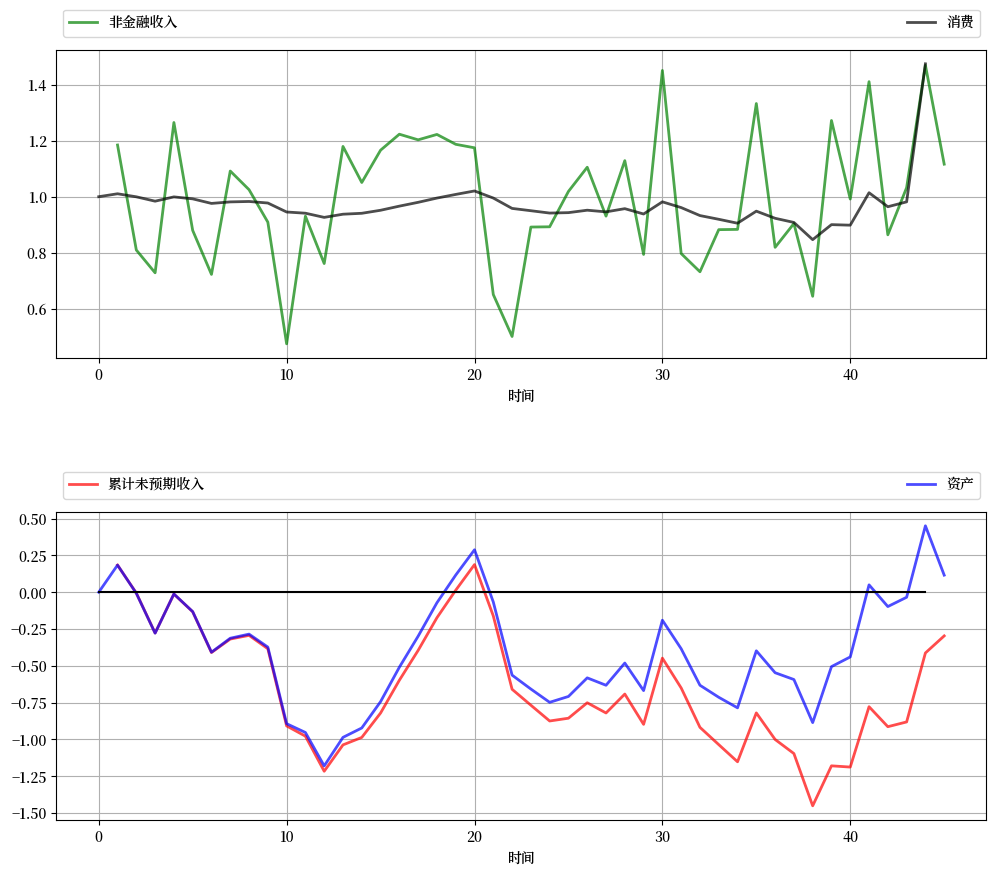

In [3]:
# 模型参数
r = 0.05
β = 1/(1 + r)
T = 45
c_bar = 2
σ = 0.25
μ = 1
q = 1e6

# 构建为LQ问题
Q = 1
R = np.zeros((2, 2))
Rf = np.zeros((2, 2))
Rf[0, 0] = q
A = [[1 + r, -c_bar + μ],
    [0,              1]]
B = [[-1],
    [ 0]]
C = [[σ],
    [0]]

# 计算解并模拟
lq = LQ(Q, R, A, B, C, beta=β, T=T, Rf=Rf)
x0 = (0, 1)
xp, up, wp = lq.compute_sequence(x0)

# 转换回资产、消费和收入
assets = xp[0, :]           # a_t
c = up.flatten() + c_bar    # c_t
income = σ * wp[0, 1:] + μ  # y_t

# 绘制结果
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="非金融收入",
            **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="消费", **p_args)

axes[1].plot(list(range(1, T+1)), np.cumsum(income - μ), 'r-',
            label="累计未预期收入", **p_args)
axes[1].plot(list(range(T+1)), assets, 'b-', label="资产", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')

for ax in axes:
    ax.grid()
    ax.set_xlabel('时间')
    ax.legend(ncol=2, **legend_args)

plt.show()

上图的第一面板显示了模拟中消费 $c_t$ 和收入 $y_t$ 的时间路径。

正如关于消费平滑的讨论中所预期的那样，消费的时间路径比收入的时间路径要平滑得多。

（但请注意，在生命周期末期，消费变得更加不规则，这是因为零期末资产要求对消费选择的影响更大。）

图中的第二个面板显示，资产 $a_t$ 的时间路径与累积未预期收入密切相关，后者定义为

$$
z_t := \sum_{j=0}^t \sigma w_t
$$

一个关键信息是，未预期的意外收益会被储蓄而不是消费，而未预期的负面冲击则通过减少资产来应对。

（同样，由于零期末资产要求，这种关系在生命周期末期也会被打破。）

这些结果对参数变化相对稳健。

例如，我们把 $\beta$ 从 $1 / (1 + r) \approx 0.952$ 增加到 $0.96$，同时保持其他参数不变。

这个消费者比之前的更有耐心，因此对后期消费赋予相对更大的权重。

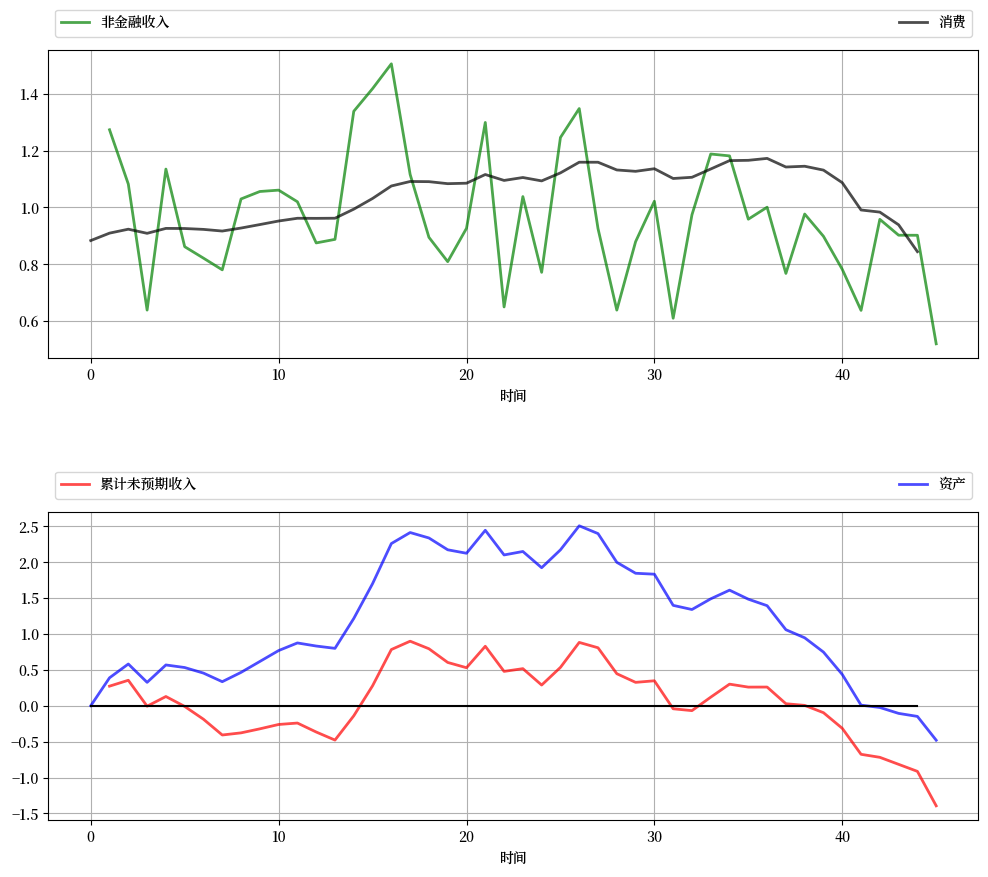

In [4]:
# 计算解并模拟
lq = LQ(Q, R, A, B, C, beta=0.96, T=T, Rf=Rf)
x0 = (0, 1)
xp, up, wp = lq.compute_sequence(x0)

# 转换回资产、消费和收入
assets = xp[0, :]           # a_t
c = up.flatten() + c_bar    # c_t
income = σ * wp[0, 1:] + μ  # y_t

# 绘制结果
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(list(range(1, T+1)), income, 'g-', label="非金融收入",
             **p_args)
axes[0].plot(list(range(T)), c, 'k-', label="消费", **p_args)

axes[1].plot(list(range(1, T+1)), np.cumsum(income - μ), 'r-',
             label="累计未预期收入", **p_args)
axes[1].plot(list(range(T+1)), assets, 'b-', label="资产", **p_args)
axes[1].plot(list(range(T)), np.zeros(T), 'k-')

for ax in axes:
    ax.grid()
    ax.set_xlabel('时间')
    ax.legend(ncol=2, **legend_args)

plt.show()

现在我们有一个缓慢上升的消费路径，以及在中期出现驼峰形状的资产积累来为不断增长的消费提供资金。

然而，基本特征保持不变：相对于收入而言，消费是平滑的，且资产与累积的未预期收入呈强烈的正相关。

## 扩展和评论

让我们现在考虑上述LQ问题的一些标准扩展。

### 时变参数

在某些情形下，我们可能希望允许参数 $A, B, C, R, Q$ 随时间 $t$ 变化。

为简化分析，我们在后文实现中未考虑这一扩展。

不过，这样的简化并不会造成显著的普遍性损失。

事实上，通过适当扩展状态变量，我们仍可处理许多具有时变参数的模型。

{ref}`下面 <lq_nsi>`给出了一个简单说明。

要了解更多示例和更系统的处理方法，请参见{cite}`HansenSargent2013`第2.4节。

(lq_cpt)=

### 添加交叉乘积项

在某些LQ问题中，偏好包含一个交叉乘积项$u_t' N x_t$，使得目标函数变为

```{math}
:label: lq_object_cp

\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t) + \beta^T x_T' R_f x_T
\right\}
```

我们的结果可以直接扩展到这种情形。

{eq}`lq_pr`中的序列 $\{P_t\}$ 变为

```{math}
:label: lq_pr_cp

P_{t-1} = R - (\beta B' P_t A + N)'
(Q + \beta B' P_t B)^{-1} (\beta B' P_t A + N) +
\beta A' P_t A
\quad \text{且} \quad
P_T = R_f
```

{eq}`lq_oc`中的策略修改为

```{math}
:label: lq_oc_cp

u_t  = - F_t x_t
\quad \text{其中} \quad
F_t := (Q + \beta B' P_{t+1} B)^{-1} (\beta B' P_{t+1} A + N)
```

 式{eq}`lq_dd`中的序列 $\{d_t\}$保持不变。

我们让感兴趣的读者自行验证这些结果（计算过程虽然冗长但并不特别困难）。

(lq_ih)=
### 无限期限

```{index} single: LQ Control; Infinite Horizon
```

最后，我们考虑无限期情形，带有{ref}`交叉项 <lq_cpt>`，而系统动态与目标函数的形式保持不变：

```{math}
:label: lq_object_ih

\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t (x_t' R x_t + u_t' Q u_t + 2 u_t' N x_t)
\right\}
```

在无限期情形下，最优策略只有在时间 $t$ 本身是状态向量 $x_t$ 的一个分量时才会依赖于时间。

换句话说，存在一个固定矩阵$F$，使得对所有 $t$ 都有 $u_t = -F x_t$。

决策规则随时间保持不变是直观的——毕竟，决策者在每个阶段都面临相同的无限期，只是当前状态在变化。

不出所料，$P$ 和 $d$也是常数。

稳态矩阵 $P$ 是[离散时间代数黎卡提方程](https://blog.csdn.net/weixin_36815313/article/details/111773535#:~:text=%E4%BB%A3%E6%95%B0%20Riccati%20%E6%96%B9%E7%A8%8B%EF%BC%88algebr)的解。

(riccati_equation)=
```{math}
:label: lq_pr_ih

P = R - (\beta B' P A + N)'
(Q + \beta B' P B)^{-1} (\beta B' P A + N) +
\beta A' P A
```

方程 {eq}`lq_pr_ih` 也被称为 *LQ 贝尔曼方程*，将给定的 $P$ 映射到 {eq}`lq_pr_ih` 右侧的映射被称为 *LQ 贝尔曼算子*。

这个模型的时间不变的最优策略是

```{math}
:label: lq_oc_ih

u  = - F x
\quad \text{其中} \quad
F = (Q + \beta B' P B)^{-1} (\beta B' P A + N)
```

{eq}`lq_dd` 中的序列 $\{d_t\}$ 被常数值替代

```{math}
:label: lq_dd_ih

d
:= \mathop{\mathrm{trace}}(C' P C) \frac{\beta}{1 - \beta}
```

状态按照时间齐次过程 $x_{t+1} = (A - BF) x_t + C w_{t+1}$ 演化。

一个无限期问题的例子将在{ref}`下文 <lqc_mwac>` 中讨论。

(lq_cert_eq)=
### 确定性等价

上述类别的线性二次控制问题具有*确定性等价*的性质。

我们的意思是，最优策略 $F$ 不受指定冲击过程的参数 $C$ 的影响。

这一点可以通过检查 {eq}`lq_oc_ih` 或 {eq}`lq_oc_cp` 来确认。

因此，在求解最优行为时我们可以忽略不确定性，而在研究最优状态动态时再将其纳入考虑。

## 进一步应用

(lq_nsi)=
### 应用1：与年龄相关的收入过程

{ref}`此前 <lq_mfpa>` 我们研究了一个永久收入模型，该模型产生了消费平滑的结果。

然而，该模型有一个不太现实的假设：随机收入过程的均值不随消费者年龄而变化。

一个更现实的收入轨迹是：在工作早期阶段上升，在中期达到峰值，随后逐渐下降，并在退休阶段进一步下滑。

在本节中，我们将使用关于年龄的多项式函数，对这种对称的倒 “U” 形收入模式进行建模。

和之前一样，消费者最小化以下目标函数：

```{math}
:label: lq_pip

\mathbb E \,
\left\{
    \sum_{t=0}^{T-1} \beta^t (c_t - \bar c)^2 + \beta^T q a_T^2
\right\}
```

约束条件为 $a_{t+1} = (1 + r) a_t - c_t + y_t, \ t \geq 0$。

对于收入，我们现在假设 $y_t = p(t) + \sigma w_{t+1}$，其中 $p(t) := m_0 + m_1 t + m_2 t^2$。

(在{ref}`下一节 <lq_nsi2>`中，我们将使用一些技巧来实现一个更复杂的模型。)

系数 $m_0, m_1, m_2$ 的选择使得 $p(0)=0, p(T/2) = \mu$，且 $p(T)=0$。

你可以确认 $m_0 = 0, m_1 = T \mu / (T/2)^2, m_2 = - \mu / (T/2)^2$ 满足上述条件。

为了将该问题写入 LQ 框架，预算约束可写为：

```{math}
:label: lq_hib

a_{t+1} = (1 + r) a_t - u_t - \bar c + m_1 t + m_2 t^2 + \sigma w_{t+1}
```

注意，$a_{t+1}$ 是 $(a_t, 1, t, t^2)$ 的线性函数，因此我们将这四个变量作为状态向量 $x_t$。


一旦对状态变量与控制变量作出合适的选择（回忆 $u_t = c_t - \bar c$ ），
其余部分的设定就相对容易确定。

因此，对于动态系统，我们设定

```{math}
:label: lq_lowmc3

x_t :=
\left(
\begin{array}{c}
a_t \\
1 \\
t \\
t^2
\end{array}
\right),
\quad
A :=
\left(
\begin{array}{cccc}
1 + r & -\bar c & m_1 & m_2 \\
0     & 1       & 0   & 0   \\
0     & 1       & 1   & 0   \\
0     & 1       & 2   & 1
\end{array}
\right),
\quad
B :=
\left(
\begin{array}{c}
-1 \\
0 \\
0 \\
0
\end{array}
\right),
\quad
C :=
\left(
\begin{array}{c}
\sigma \\
0 \\
0 \\
0
\end{array}
\right)
```

如果你使用这个设定展开表达式 $x_{t+1} = A x_t + B u_t + C w_{t+1}$，你会发现资产按照期望的方式遵循{eq}`lq_hib`，且其他状态变量也会适当更新。

为了实现偏好函数{eq}`lq_pip`，我们取

```{math}
:label: lq_4sp

Q := 1,
\quad
R :=
\left(
\begin{array}{cccc}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right)
\quad \text{和} \quad
R_f :=
\left(
\begin{array}{cccc}
q & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right)
```

下图显示了使用`lqcontrol.py`中的`compute_sequence`方法计算的消费和资产的模拟结果，初始资产设为零。

(solution_lqc_ex1_fig)=
```{figure} /_static/lecture_specific/lqcontrol/solution_lqc_ex1.png

```

再次可以看到，平滑消费是样本路径的一个主要特征。

资产路径展现出与标准生命周期理论相一致的动态特征。

{ref}`lqc_ex1`给出了此处使用的完整参数集，并要求你复现该图。

(lq_nsi2)=
### 应用2：包含退休的永久收入模型

在{ref}`前一个应用<lq_nsi>`中，我们使用多项式生成了一个倒“U”形的收入动态，并将其置于LQ框架中。

可以说，这个收入过程仍然包含一些不切实际的特征。

更常见的收入模式是

1. 在整个工作期内，收入随时间上升，并围绕上升趋势波动；到中后期增长趋缓；
1. 退休后，收入较低但相对稳定（非金融收入）

令 $K$ 为退休日期，我们可以用以下方式表达这些收入动态

```{math}
:label: lq_cases

y_t =
\begin{cases}
p(t) + \sigma w_{t+1} & \quad \text{如果 } t \leq K  \\
s                     & \quad \text{其他情况}
\end{cases}
```

其中

* $p(t) := m_1 t + m_2 t^2$，其中系数 $m_1, m_2$ 的选择使得 $p(K) = \mu$ 且 $p(0) = p(2K)=0$
* $s$ 是退休收入

我们假设偏好保持不变，由{eq}`lq_pio`给出。

预算约束也保持不变，由 $a_{t+1} = (1 + r) a_t - c_t + y_t$ 给出。

我们的目标是利用本讲所介绍的 LQ 技术来求解该问题，并模拟相应的路径。

事实上，这是一个不简单的问题，因为在 $K$ 处动态方程{eq}`lq_cases`的拐点使得很难将运动规律表示为固定系数的线性系统。

然而，我们仍可通过连接两个 LQ 子问题的方式来求解。

这两个LQ问题分别描述了消费者在工作期间(`lq_working`)和退休期间(`lq_retired`)的行为。

(这是可行的，因为在生命的这两个不同阶段，各自的收入过程（多项式趋势和常数）都符合LQ框架。)

基本思路是，尽管整个问题不是单一的时不变LQ问题，但它仍然是一个动态规划问题，因此我们可以在每个阶段使用适当的贝尔曼方程。

基于这个逻辑，我们可以：

1. 通过常规的逆向归纳程序求解`lq_retired`，从退休终点向前迭代。
1. 将通过此过程生成的退休初始值函数作为终端条件 $R_f$，输入到 `lq_working` 规范中。
1. 从这个选定的 $R_f$ 开始，通过逆向归纳法求解 `lq_working`，一直迭代回工作生涯开始时。

这个过程给出了整个生命周期的值函数序列和最优策略。

下图显示了基于这个程序的一个模拟结果。

(solution_lqc_ex2_fig)=
```{figure} /_static/lecture_specific/lqcontrol/solution_lqc_ex2.png

```

模拟中使用的完整参数集在{ref}`lqc_ex2`中讨论，并要求读者复现该图。

再次强调，在模拟中可以观察到的主要特征是消费平滑。

资产路径与标准生命周期理论相符，年轻时期存在负储蓄，随后进入正储蓄阶段。

资产在退休时达到峰值，之后逐渐下降。

(lqc_mwac)=
### 应用3：具有调整成本的垄断

考虑一个垄断者面临以下逆需求函数：

$$
p_t = a_0 - a_1 q_t + d_t
$$

这里 $q_t$ 是产量，需求冲击 $d_t$ 遵循

$$
d_{t+1} = \rho d_t + \sigma w_{t+1}
$$

其中 $\{w_t\}$ 是独立同分布的标准正态分布。

垄断者最大化未来折现利润流的期望值：

```{math}
:label: lq_object_mp

\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t
    \pi_t
\right\}
\quad \text{其中} \quad
\pi_t := p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2
```

这里

* $\gamma (q_{t+1} - q_t)^2$ 表示调整成本
* $c$ 是平均生产成本

这一问题可以被表述为 LQ 控制问题并进行求解与模拟。

在正式求解前，我们先研究这个问题以得到一些直观理解。

思考这个问题的一种方式是考虑如果 $\gamma = 0$ 会发生什么。

没有调整成本就没有跨期权衡，所以垄断者将在每个时期选择产量以最大化当期利润。

不难证明利润最大化的产出为

$$
\bar q_t := \frac{a_0 - c + d_t}{2 a_1}
$$

根据这个讨论，对于一般的 $\gamma$ 值，我们可以预期：

* 如果 $\gamma$ 接近零，那么 $q_t$ 会相对紧密地跟踪 $\bar q_t$ 的时间路径。
* 如果 $\gamma$ 较大，那么 $q_t$ 会比 $\bar q_t$ 更平滑，因为垄断者试图避免调整成本。

这种直觉是正确的。

以下图表显示了通过求解相应的LQ问题所产生的模拟结果。

这些图表之间的参数唯一区别是$\gamma$的大小

```{figure} /_static/lecture_specific/lqcontrol/solution_lqc_ex3_g1.png

```

```{figure} /_static/lecture_specific/lqcontrol/solution_lqc_ex3_g10.png

```

```{figure} /_static/lecture_specific/lqcontrol/solution_lqc_ex3_g50.png

```

为了生成这些图，我们将垄断者问题转换为一个LQ问题。

这种转换的关键在于选择正确的状态变量——这有点像一门艺术。

这里我们取 $x_t = (\bar q_t \;\, q_t \;\, 1)'$，而控制变量选择为 $u_t = q_{t+1} - q_t$。

我们还对利润函数做了轻微调整。

在{eq}`lq_object_mp`中，当期利润为$\pi_t := p_t q_t - c q_t - \gamma (q_{t+1} - q_t)^2$。

现在让我们在{eq}`lq_object_mp`中用 $\hat \pi_t := \pi_t - a_1 \bar q_t^2$ 替换 $\pi_t$。

这对最优解没有影响，因为 $a_1 \bar q_t^2$ 不依赖于控制变量。

（实际上，我们只是在{eq}`lq_object_mp`中添加了一个常数项，而优化结果不受常数项影响。）

进行这种替换的原因是，正如你将能够验证的那样，$\hat \pi_t$ 可以简化为简单的二次形式

$$
\hat \pi_t = -a_1 (q_t - \bar q_t)^2 - \gamma u_t^2
$$

在转换为最小化问题后（通过取负），目标函数变为

```{math}
:label: lq_object_mp2

\min
\mathbb E \,
\sum_{t=0}^{\infty} \beta^t
\left\{
    a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
\right\}
```

现在找到 $R$ 和 $Q$， 使得{eq}`lq_object_mp2`可以写成{eq}`lq_object_ih`的形式。

此外，通过写出状态每个元素的动态方程，可以找到{eq}`lq_lom`中的矩阵 $A, B$ 和 $C$。

{ref}`lqc_ex3`要求你完成这个过程，并复现前面的图表。

## 练习


```{exercise}
:label: lqc_ex1

复现{ref}`上面所示<solution_lqc_ex1_fig>`的多项式收入曲线图。

参数为 $r = 0.05, \beta = 1 / (1 + r), \bar c = 1.5,  \mu = 2, \sigma = 0.15, T = 50$ 和 $q = 10^4$。
```

```{solution-start} lqc_ex1
:class: dropdown
```

以下是一种可行的解法。

我们使用了一些绘图样式指令以获得更美观的输出 —— 当然你也可以使用更简洁的绘图代码。

这个模型是一个具有驼峰形收入的LQ永久收入/生命周期模型

$$
y_t = m_1 t + m_2 t^2 + \sigma w_{t+1}
$$

其中 $\{w_t\}$ 是独立同分布的 $N(0, 1)$ 随机变量，系数 $m_1$ 和 $m_2$ 的选择使得 $p(t) = m_1 t + m_2 t^2$ 呈现倒 U 形，且满足：

- $p(0) = 0, p(T/2) = \mu$，以及
- $p(T) = 0$

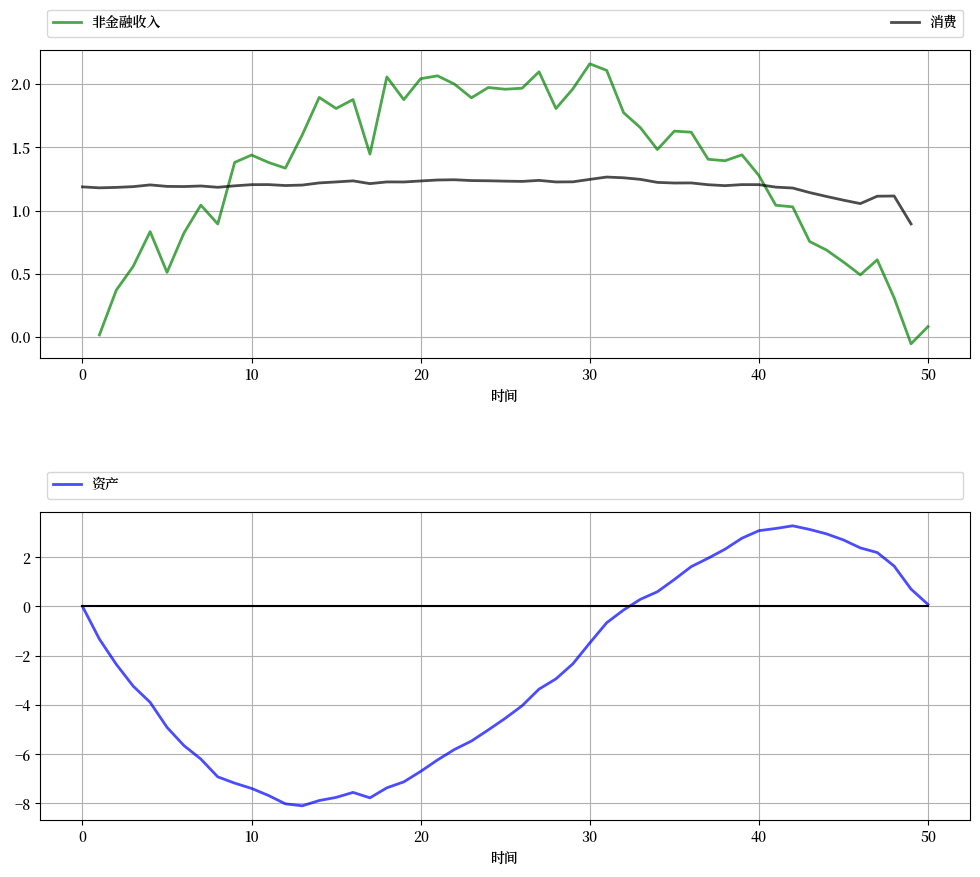

In [5]:
# 模型参数
r = 0.05
β = 1/(1 + r)
T = 50
c_bar = 1.5
σ = 0.15
μ = 2
q = 1e4
m1 = T * (μ/(T/2)**2)
m2 = -(μ/(T/2)**2)

# 构建为 LQ 问题
Q = 1
R = np.zeros((4, 4))
Rf = np.zeros((4, 4))
Rf[0, 0] = q
A = [[1 + r, -c_bar, m1, m2],
     [0,          1,  0,  0],
     [0,          1,  1,  0],
     [0,          1,  2,  1]]
B = [[-1],
     [ 0],
     [ 0],
     [ 0]]
C = [[σ],
     [0],
     [0],
     [0]]

# 计算解并模拟
lq = LQ(Q, R, A, B, C, beta=β, T=T, Rf=Rf)
x0 = (0, 1, 0, 0)
xp, up, wp = lq.compute_sequence(x0)

# 将结果转换回资产、消费和收入
ap = xp[0, :]               # 资产
c = up.flatten() + c_bar    # 消费
time = np.arange(1, T+1)
income = σ * wp[0, 1:] + m1 * time + m2 * time**2  # 收入


# 绘制结果
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(range(1, T+1), income, 'g-', label="非金融收入",
            **p_args)
axes[0].plot(range(T), c, 'k-', label="消费", **p_args)

axes[1].plot(range(T+1), ap.flatten(), 'b-', label="资产", **p_args)
axes[1].plot(range(T+1), np.zeros(T+1), 'k-')

for ax in axes:
    ax.grid()
    ax.set_xlabel('时间')
    ax.legend(ncol=2, **legend_args)
plt.show()

```{solution-end}
```

````{exercise}
:label: lqc_ex2

复现{ref}`上面所示<solution_lqc_ex2_fig>`关于工作和退休的图。

参数为 $r = 0.05, \beta = 1 / (1 + r), \bar c = 4,  \mu = 4, \sigma = 0.35, K = 40, T = 60, s = 1$ 和 $q = 10^4$。

为理解整体流程，请仔细阅读该图所在的章节。

```{hint}
:class: dropdown

首先,为了使我们的方法有效,我们必须确保两个LQ问题具有相同的状态变量和控制变量。

与之前的应用一样,控制变量可以设置为 $u_t = c_t - \bar c$。

对于`lq_working`, $x_t, A, B, C$ 可以按照{eq}`lq_lowmc3`中的方式选择。

* 请记住，选择 $m_1, m_2$ 使得 $p(K) = \mu$ 且 $p(2K)=0$。

对于`lq_retired`，使用相同的 $x_t$ 和 $u_t$ 定义，但修改 $A, B, C$ 以对应固定收入 $y_t = s$。

对于`lq_retired`，按照{eq}`lq_4sp`设置偏好。

对于`lq_working`，偏好相同，但其终值条件 $R_f$ 应替换为由`lq_retired`从退休期末逆向迭代至退休起点所得到的最终值函数。

通过仔细处理，可以将这两个独立模型的模拟结果拼接在一起生成完整的模拟。
````

```{solution-start} lqc_ex2
:class: dropdown
```

这是一个永久收入/生命周期模型，工作期间收入呈多项式增长，退休后收入固定。

该模型通过组合两个LQ规划问题来求解，正如讲座中所述。

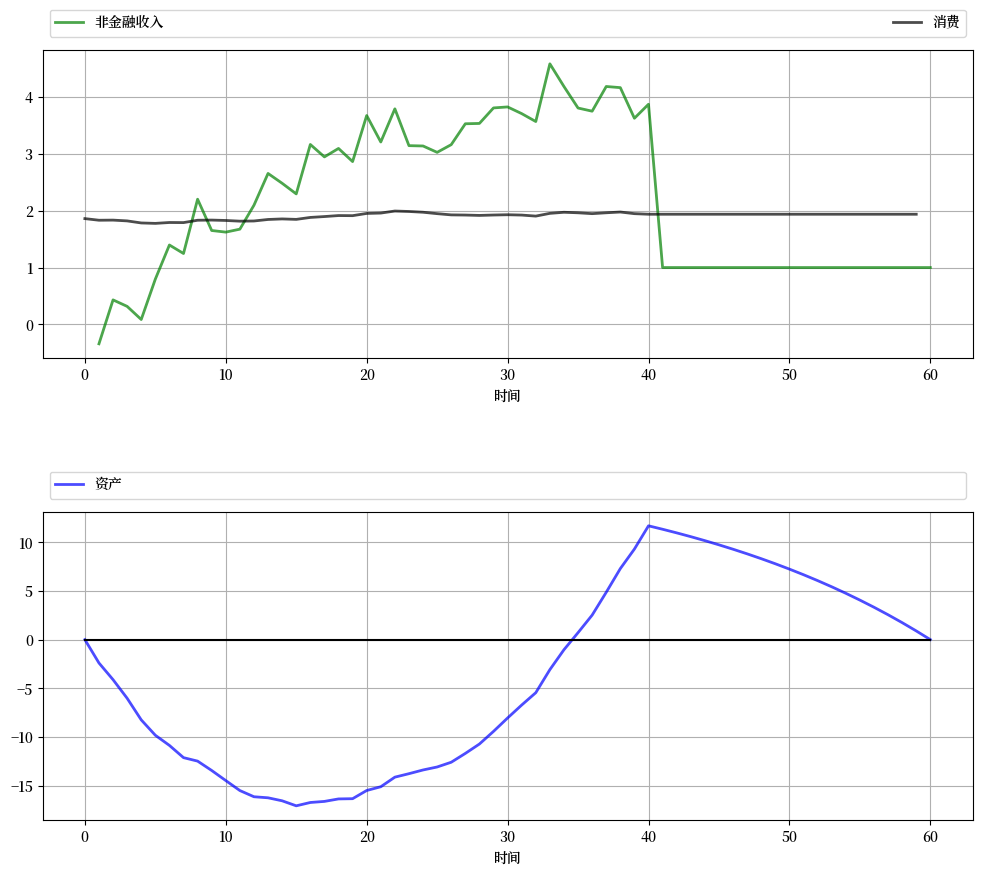

In [6]:
# 模型参数
r = 0.05
β = 1/(1 + r)
T = 60
K = 40
c_bar = 4
σ = 0.35
μ = 4
q = 1e4
s = 1
m1 = 2 * μ/K
m2 = -μ/K**2

# 构建LQ问题1(退休期)
Q = 1
R = np.zeros((4, 4))
Rf = np.zeros((4, 4))
Rf[0, 0] = q
A = [[1 + r, s - c_bar, 0, 0],
     [0,             1, 0, 0],
     [0,             1, 1, 0],
     [0,             1, 2, 1]]
B = [[-1],
     [ 0],
     [ 0],
     [ 0]]
C = [[0],
     [0],
     [0],
     [0]]

# 为退休人员初始化LQ实例
lq_retired = LQ(Q, R, A, B, C, beta=β, T=T-K, Rf=Rf)
# 迭代回退休开始时,记录最终值函数
for i in range(T-K):
    lq_retired.update_values()
Rf2 = lq_retired.P

# 构建LQ问题2(工作期)
R = np.zeros((4, 4))
A = [[1 + r, -c_bar, m1, m2],
     [0,          1,  0,  0],
     [0,          1,  1,  0],
     [0,          1,  2,  1]]
B = [[-1],
     [ 0],
     [ 0],
     [ 0]]
C = [[σ],
     [0],
     [0],
     [0]]

# 使用lq_retired的终值Rf设置工作期LQ实例
lq_working = LQ(Q, R, A, B, C, beta=β, T=K, Rf=Rf2)

# 模拟工作期状态/控制路径
x0 = (0, 1, 0, 0)
xp_w, up_w, wp_w = lq_working.compute_sequence(x0)
# 模拟退休期路径(注意初始条件)
xp_r, up_r, wp_r = lq_retired.compute_sequence(xp_w[:, K])

# 将结果转换回资产、消费和收入
xp = np.column_stack((xp_w, xp_r[:, 1:]))
assets = xp[0, :]                  # 资产

up = np.column_stack((up_w, up_r))
c = up.flatten() + c_bar           # 消费

time = np.arange(1, K+1)
income_w = σ * wp_w[0, 1:K+1] + m1 * time + m2 * time**2  # 收入
income_r = np.full(T-K, s)
income = np.concatenate((income_w, income_r))

# 绘制结果
n_rows = 2
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 10))

plt.subplots_adjust(hspace=0.5)

bbox = (0., 1.02, 1., .102)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.7}

axes[0].plot(range(1, T+1), income, 'g-', label="非金融收入",
            **p_args)
axes[0].plot(range(T), c, 'k-', label="消费", **p_args)

axes[1].plot(range(T+1), assets, 'b-', label="资产", **p_args)
axes[1].plot(range(T+1), np.zeros(T+1), 'k-')

for ax in axes:
    ax.grid()
    ax.set_xlabel('时间')
    ax.legend(ncol=2, **legend_args)
plt.show()

```{solution-end}
```

```{exercise}
:label: lqc_ex3

复现{ref}`上述 <lqc_mwac>`垄断者应用中的图形。

参数设置为 $a_0 = 5, a_1 = 0.5, \sigma = 0.15, \rho = 0.9,
\beta = 0.95$ 和 $c = 2$，而 $\gamma$ 在1到50之间变化
(参见图形)。
```

```{solution-start} lqc_ex3
:class: dropdown
```

第一个任务是找到定义LQ问题的矩阵 $A, B, C, Q, R$。

回顾一下 $x_t = (\bar q_t \;\, q_t \;\, 1)'$，而 $u_t = q_{t+1} - q_t$。

令 $m_0 := (a_0 - c) / 2a_1$ 且 $m_1 := 1 / 2 a_1$，我们
可以写成 $\bar q_t = m_0 + m_1 d_t$，然后经过一些
推导

$$
\bar q_{t+1} = m_0 (1 - \rho) + \rho \bar q_t + m_1 \sigma w_{t+1}
$$

根据我们对 $u_t$ 的定义，$q_t$ 的动态方程为 $q_{t+1} = q_t + u_t$。

使用这些事实，你应该能够构建正确的$A, B, C$ 矩阵（然后与下面代码中的矩阵进行对照）。

通过检查目标函数可以找到合适的 $R, Q$ 矩阵，为方便起见，我们在此重复该目标函数：

$$
\min
\mathbb E \,
\left\{
    \sum_{t=0}^{\infty} \beta^t
    a_1 ( q_t - \bar q_t)^2 + \gamma u_t^2
\right\}
$$

我们的代码如下：

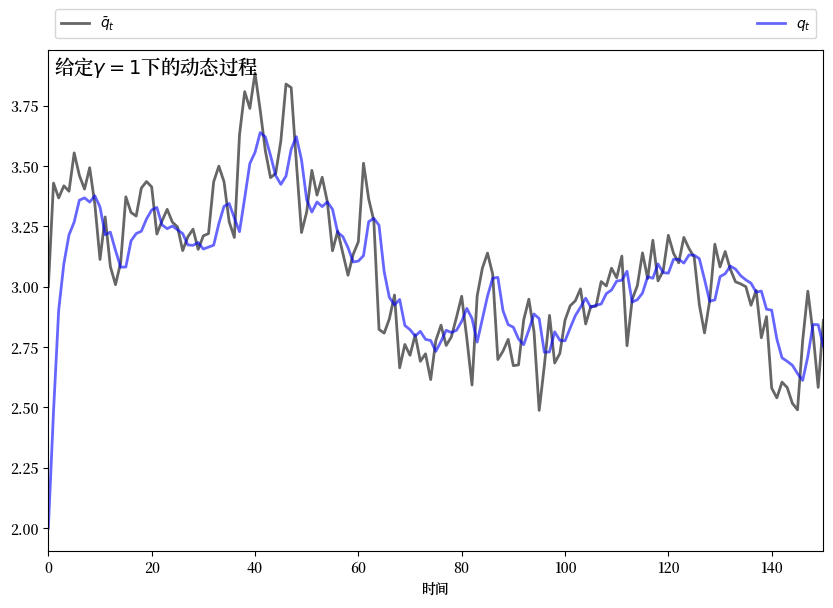

In [7]:
# 模型参数
a0 = 5
a1 = 0.5
σ = 0.15
ρ = 0.9
γ = 1
β = 0.95
c = 2
T = 120

# 有用的常数
m0 = (a0-c)/(2 * a1)
m1 = 1/(2 * a1)

# 构建LQ问题
Q = γ
R = [[ a1, -a1,  0],
     [-a1,  a1,  0],
     [  0,   0,  0]]
A = [[ρ, 0, m0 * (1 - ρ)],
     [0, 1,            0],
     [0, 0,            1]]

B = [[0],
     [1],
     [0]]
C = [[m1 * σ],
     [     0],
     [     0]]

lq = LQ(Q, R, A, B, C=C, beta=β)

# 模拟状态/控制路径
x0 = (m0, 2, 1)
xp, up, wp = lq.compute_sequence(x0, ts_length=150)
q_bar = xp[0, :]
q = xp[1, :]

# 绘制模拟结果
fig, ax = plt.subplots(figsize=(10, 6.5))

# 一些复杂的绘图设置
bbox = (0., 1.01, 1., .101)
legend_args = {'bbox_to_anchor': bbox, 'loc': 3, 'mode': 'expand'}
p_args = {'lw': 2, 'alpha': 0.6}

time = range(len(q))
ax.set(xlabel='时间', xlim=(0, max(time)))
ax.plot(time, q_bar, 'k-', lw=2, alpha=0.6, label=r'$\bar q_t$')
ax.plot(time, q, 'b-', lw=2, alpha=0.6, label='$q_t$')
ax.legend(ncol=2, **legend_args)
s = fr'给定$\gamma = {γ}$下的动态过程'
ax.text(min(time) + 1, 1 * q_bar.max(), s, fontsize=14)
plt.show()

```{solution-end}
```